# SRI Ward

In [1]:
# Importaciones de bibliotecas y módulos necesarios
import os
import subprocess
import unidecode
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

En la siguiente parte, donde dice start_url cambiala por la que gustes. Creará una carpeta llamada paginas en caso de que no exista y si existe dentro de usa carpeta creará otro subdirectorio con la fecha y hora de hoy para ordenarlos y seprarlos, en caso de que solo necesites leer los de una carpeta y ya no necesites scrapear o descargar nuevos archivos.

In [2]:
# Importa el módulo subprocess para ejecutar comandos del sistema
import subprocess

# Define un comando para ejecutar un spider de Scrapy, especificando la URL de inicio y la profundidad
comando = ["scrapy", "crawl", "sp_ward", "-a", "start_url=https://es.wikipedia.org/wiki/Puedo_prometer_y_prometo", "-a", "depth=2"]
# Ejecuta el comando en un directorio específico
subprocess.run(comando, cwd="../Tercera Práctica/SC_WARD/")

CompletedProcess(args=['scrapy', 'crawl', 'sp_ward', '-a', 'start_url=https://es.wikipedia.org/wiki/Puedo_prometer_y_prometo', '-a', 'depth=2'], returncode=0)

In [41]:
# Define una función para listar subcarpetas en un directorio dado
def listar_subcarpetas(ruta):
    # Utiliza list comprehension para crear una lista de subcarpetas
    subcarpetas = [carpeta for carpeta in os.listdir(ruta) if os.path.isdir(os.path.join(ruta, carpeta))]
    return subcarpetas

In [42]:
# Define una función para leer archivos de texto de un directorio
def leer_archivos(directorio):
    textos = []  # Lista para almacenar los textos leídos
    # Itera sobre los archivos en el directorio
    for archivo in os.listdir(directorio):
        # Chequea si el archivo es un archivo de texto
        if archivo.endswith(".txt"):
            # Abre y lee el archivo, añadiendo su contenido a la lista de textos
            with open(os.path.join(directorio, archivo), 'r', encoding='utf-8', errors='ignore') as f:
                textos.append(f.read())
    return textos

In [43]:
# Define una función para procesar texto HTML y obtener palabras limpias
def procesar_texto(html):
    # Utiliza BeautifulSoup para eliminar etiquetas HTML y obtener texto plano
    soup = BeautifulSoup(html, 'html.parser')
    texto = soup.get_text()

    # Tokeniza el texto y normaliza a minúsculas, eliminando acentos
    tokens = word_tokenize(texto, language='spanish')
    palabras = [eliminar_acentos(palabra.lower()) for palabra in tokens if palabra.isalpha()]

    # Elimina stopwords en español y palabras de longitud menor a 3
    palabras_sin_stopwords = [palabra for palabra in palabras if palabra not in stopwords.words('spanish') and len(palabra) > 2]
    return palabras_sin_stopwords

In [44]:
# Define una función para eliminar acentos de las palabras
def eliminar_acentos(palabra):
    return unidecode.unidecode(palabra)

In [45]:
# Define una función para crear un diccionario de términos a partir de una lista de textos
def crear_diccionario(textos):
    diccionario = set()  # Utiliza un conjunto para almacenar términos únicos
    # Actualiza el diccionario con palabras de cada texto
    for texto in textos:
        diccionario.update(texto)
    return diccionario

In [46]:
# Define una función para guardar el diccionario en un archivo
def guardar_diccionario(diccionario, nombre_archivo):
    with open(nombre_archivo, 'w', encoding='utf-8') as f:
        # Escribe cada término del diccionario en el archivo, ordenados alfabéticamente
        for termino in sorted(diccionario):
            f.write(termino + '\n')

In [47]:
# Interfaz para elegir una subcarpeta de un directorio de páginas scrapeadas
ruta_paginas = 'SC_WARD/paginas'
subcarpetas = listar_subcarpetas(ruta_paginas)
print("Subcarpetas disponibles:")
for idx, carpeta in enumerate(subcarpetas):
    print(f"{idx + 1}. {carpeta}")

# Permite al usuario seleccionar una subcarpeta y lee los archivos de esa carpeta
eleccion = int(input("Seleccione el número de la subcarpeta: "))
ruta_seleccionada = os.path.join(ruta_paginas, subcarpetas[eleccion - 1])
textos_scrapeados = leer_archivos(ruta_seleccionada)

# Procesa los textos scrapeados y crea un diccionario de términos
textos_procesados = [procesar_texto(html) for html in textos_scrapeados]
diccionario = crear_diccionario(textos_procesados)

# Guarda el diccionario en un archivo
guardar_diccionario(diccionario, 'diccionario.txt')
print("Diccionario guardado en 'diccionario.txt'")

Subcarpetas disponibles:
1. 20231120185519
Diccionario guardado en 'diccionario.txt'


In [48]:
# Define una función para crear una matriz booleana a partir de los textos y el diccionario
def crear_matriz(textos, diccionario, nombres_archivos):
    matriz = []  # Lista para almacenar la matriz
    diccionario_lista = sorted(list(diccionario))  # Convierte el diccionario a una lista ordenada
    # Itera sobre cada texto y su nombre de archivo correspondiente
    for texto, nombre_archivo in zip(textos, nombres_archivos):
        # Crea una fila en la matriz con valores booleanos indicando la presencia de palabras del diccionario en el texto
        fila = [palabra in texto for palabra in diccionario_lista]
        matriz.append((nombre_archivo, fila))
    return matriz, diccionario_lista

# Define una función para guardar la matriz booleana en un archivo
def guardar_matriz(matriz, diccionario_lista, nombre_archivo):
    with open(nombre_archivo, 'w', encoding='utf-8') as f:
        # Escribe el encabezado con los términos del diccionario
        f.write('Archivo\t' + '\t'.join(diccionario_lista) + '\n')
        # Escribe cada fila de la matriz con el nombre del archivo y los valores booleanos
        for nombre_archivo, fila in matriz:
            f.write(nombre_archivo + '\t' + '\t'.join(['1' if val else '0' for val in fila]) + '\n')

In [49]:
# Obtiene los nombres de los archivos y crea la matriz booleana
nombres_archivos = [archivo for archivo in os.listdir(ruta_seleccionada) if archivo.endswith(".txt")]
matriz, diccionario_lista = crear_matriz(textos_procesados, diccionario, nombres_archivos)

# Guarda la matriz booleana en un archivo
guardar_matriz(matriz, diccionario_lista, 'matriz.txt')

In [50]:
# Permite al usuario ingresar una consulta y la muestra
consulta_q = input("Ingrese su consulta: ")
print(consulta_q)

Acapulco es una consulta de prueba


In [51]:
# Define una función para procesar la consulta del usuario
def procesar_consulta(consulta):
    # Elimina HTML, si hay, y normaliza el texto
    consulta_sin_html = BeautifulSoup(consulta, 'html.parser').get_text()
    tokens = word_tokenize(consulta_sin_html, language='spanish')
    palabras = [palabra.lower() for palabra in tokens if palabra.isalpha()]
    # Elimina stopwords y aplica stemming
    palabras_sin_stopwords = [palabra for palabra in palabras if palabra not in stopwords.words('spanish')]
    stemmer = SnowballStemmer('spanish')
    consulta_stemmed = [stemmer.stem(palabra) for palabra in palabras_sin_stopwords]
    return consulta_stemmed

# Procesa la consulta ingresada por el usuario
consulta_procesada = procesar_consulta(consulta_q)
print(consulta_procesada)

['acapulc', 'consult', 'prueb']


In [52]:
# Define una función para vectorizar la consulta procesada
def vectorizar_consulta(consulta, diccionario_lista):
    # Crea un vector booleano para la consulta basado en el diccionario
    return [palabra in consulta for palabra in diccionario_lista]

# Vectoriza la consulta y la muestra
vector_consulta = vectorizar_consulta(consulta_procesada, diccionario_lista)
print(vector_consulta)

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

In [53]:
# Separa los nombres de archivo y los vectores booleanos de la matriz
nombres_archivos = [fila[0] for fila in matriz]
vectores_booleanos = [fila[1] for fila in matriz]

# Convierte los vectores booleanos a un array de NumPy para manipulación matricial
matriz_np = np.array(vectores_booleanos)

# Convierte el vector de la consulta a un array de NumPy y lo añade a la matriz
vector_consulta_np = np.array(vector_consulta)
matriz_con_consulta = np.vstack([matriz_np, vector_consulta_np])

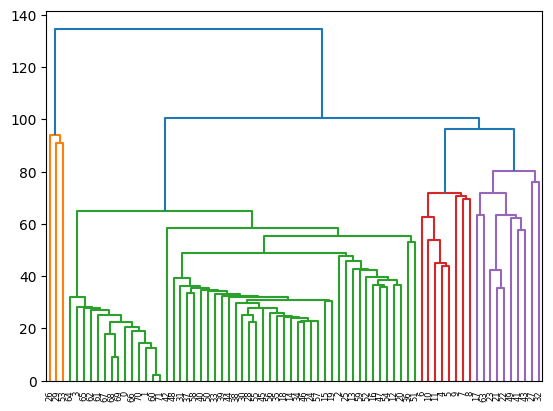

In [54]:
# Aplica el clustering aglomerativo usando el método de Ward
modelo = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
modelo = modelo.fit(matriz_con_consulta)

# Genera y muestra un dendrograma para visualizar el clustering
dendrograma = sch.dendrogram(sch.linkage(matriz_con_consulta, method='ward'))